# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [1]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.17.1


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [3]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16                                               # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/Computer_Vision_Project/images_proj.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Computer_Vision_Project/Labels_proj.csv')

In [7]:
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


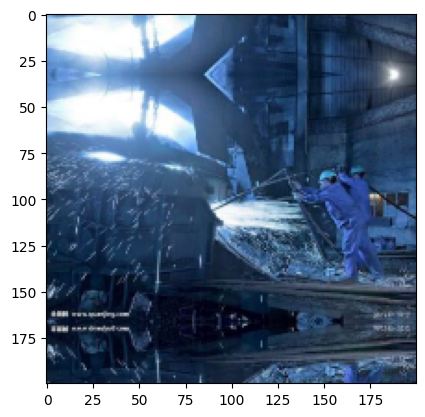

In [8]:
plt.imshow(images[5])

# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

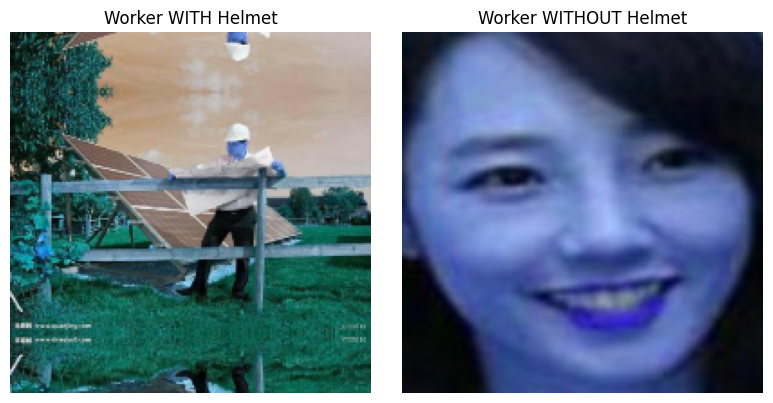

In [9]:
# separate the indices of images based on whether they show workers with or without helmets, which is useful for later analysis or visualization of specific image categories.
helmet_indices = np.where(labels == 1)[0]
no_helmet_indices = np.where(labels == 0)[0]

# Select one image from each class
helmet_img = images[np.random.choice(helmet_indices)]
no_helmet_img = images[np.random.choice(no_helmet_indices)]

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display "With Helmet" image
axes[0].imshow(helmet_img)
axes[0].set_title("Worker WITH Helmet")
axes[0].axis('off')

# Display "Without Helmet" image
axes[1].imshow(no_helmet_img)
axes[1].set_title("Worker WITHOUT Helmet")
axes[1].axis('off')

# Show the plots
plt.tight_layout()
plt.show()

## Checking for class imbalance


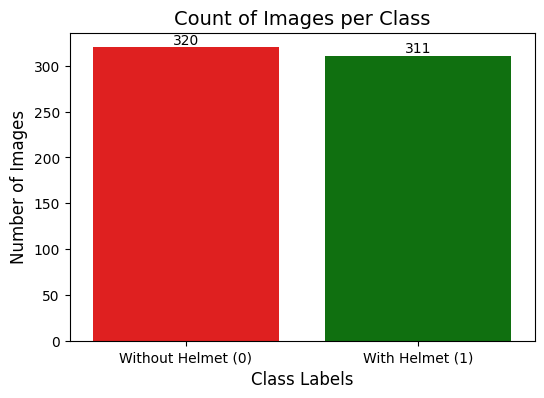

In [10]:
#Code creates a clear visualization of how many images you have for each class (with and without helmets), making it easy to see if there's a class imbalance in your dataset.
# Create a count plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels.iloc[:, 0], palette=['red', 'green'])

# Add exact counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, )

# Add labels
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Count of Images per Class", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Without Helmet (0)", "With Helmet (1)"])  # Rename x-axis labels

# Show plot
plt.show()

# **Data Preprocessing**

## Converting images to grayscale

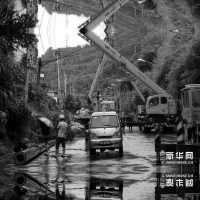

In [11]:
#converts your color images to grayscale and displays a sample grayscale image.
images_gray = []
for i in range(len(images)):
    img_gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    images_gray.append(img_gray)

# Display a sample grayscale image
n = 0  #Complete the code to define an index value
cv2_imshow(images_gray[n])

### Splitting the dataset



In [12]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.2, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

In [13]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(504, 200, 200, 3) (504, 1)
(63, 200, 200, 3) (63, 1)
(64, 200, 200, 3) (64, 1)


### Data Normalization

In [14]:
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [15]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [16]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [17]:
#sets up the architecture for your first convolutional neural network (CNN) model using the Keras Sequential API
# Initializing Model
model_1 = Sequential() #This line initializes a Sequential model, which is a linear stack of layers. This is a simple way to build a neural network where data flows directly from one layer to the next.

# Convolutional layers
#This adds a 2D convolutional layer to the model.
#32: This is the number of filters in this convolutional layer. Filters are like small patterns that the layer learns to detect in the input image.
#(3, 3): This is the size of the convolutional kernel (filter). It's a 3x3 matrix that slides over the input image.
#activation='relu': This specifies the activation function for the layer, which is the Rectified Linear Unit (ReLU). ReLU introduces non-linearity into the model, allowing it to learn more complex patterns.
#padding="same": This adds padding to the input image so that the output feature map has the same spatial dimensions as the input.
#defines the shape of the input images for the first layer. Since your images are 200x200 pixels and have 3 color channels (RGB), the shape should be (200, 200, 3).
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200,200,3)))
model_1.add(MaxPooling2D((4, 4), padding='same'))
model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function
model_1.add(MaxPooling2D((2,2), padding='same')) #Complete the code to define the shape of the pooling kernel
model_1.add(Conv2D(64,(3,3), activation='relu', padding="same")) #Complete the code to define the number of output channels,the kernel shape and the activation function

# Flatten and Dense layers
model_1.add(Flatten())
model_1.add(Dense(4, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))  #Complete the code to define the number of neurons in the output layer and the activation function

# Compile with Adam Optimizer
opt = Adam(learning_rate=0.001) #Complete the code to define the learning rate.
model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=["Accuracy","Precision"]) #Complete the code to define the metric of choice from Precision,f1_score,Recall

# Summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       160,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,329 (845.04 KB)

 Trainable params: 216,329 (845.04 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history_1 = model_1.fit(
            X_train_normalized, y_train,
            epochs=10, #Complete the code to define the number of epochs
            validation_data=(X_val_normalized,y_val),
            shuffle=True,
            batch_size=32, #Complete the code to define the batch size
            verbose=2
)

Epoch 1/10
16/16 - 17s - 1s/step - Accuracy: 0.5655 - Precision: 0.5612 - loss: 0.7136 - val_Accuracy: 0.4921 - val_Precision: 0.4921 - val_loss: 0.5572
Epoch 2/10
16/16 - 1s - 34ms/step - Accuracy: 0.8730 - Precision: 0.8026 - loss: 0.4335 - val_Accuracy: 0.9841 - val_Precision: 1.0000 - val_loss: 0.3808
Epoch 3/10
16/16 - 1s - 35ms/step - Accuracy: 0.9048 - Precision: 0.9032 - loss: 0.4416 - val_Accuracy: 0.9365 - val_Precision: 0.8857 - val_loss: 0.3577
Epoch 4/10
16/16 - 1s - 39ms/step - Accuracy: 0.9821 - Precision: 0.9650 - loss: 0.3602 - val_Accuracy: 0.9841 - val_Precision: 1.0000 - val_loss: 0.3620
Epoch 5/10
16/16 - 1s - 45ms/step - Accuracy: 0.9702 - Precision: 0.9569 - loss: 0.3603 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_loss: 0.3468
Epoch 6/10
16/16 - 0s - 29ms/step - Accuracy: 0.9861 - Precision: 0.9879 - loss: 0.3639 - val_Accuracy: 1.0000 - val_Precision: 1.0000 - val_loss: 0.3309
Epoch 7/10
16/16 - 0s - 29ms/step - Accuracy: 0.9980 - Precision: 0.9960 - lo

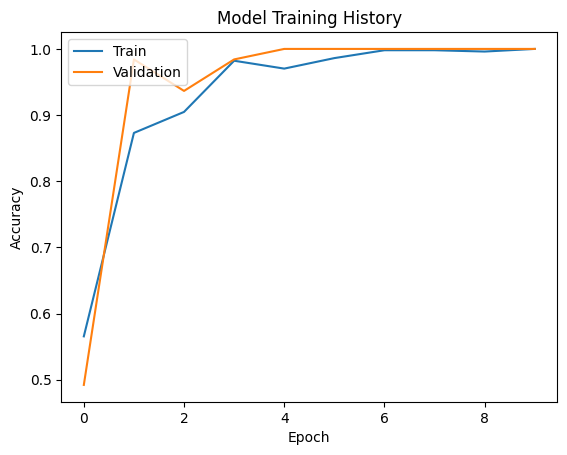

In [19]:
plt.plot(history_1.history['Accuracy'])
plt.plot(history_1.history['val_Accuracy'])
plt.title('Model Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [20]:
#calculates and prints the performance metrics using training data
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train)

print("Train performance metrics")
print(model_1_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


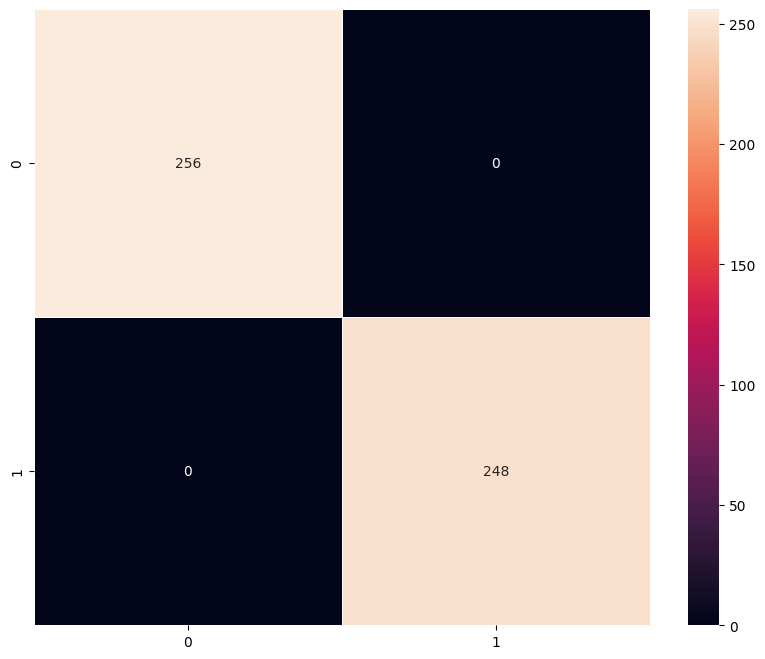

In [21]:
plot_confusion_matrix(model_1,X_train_normalized,y_train)

In [22]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_1_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


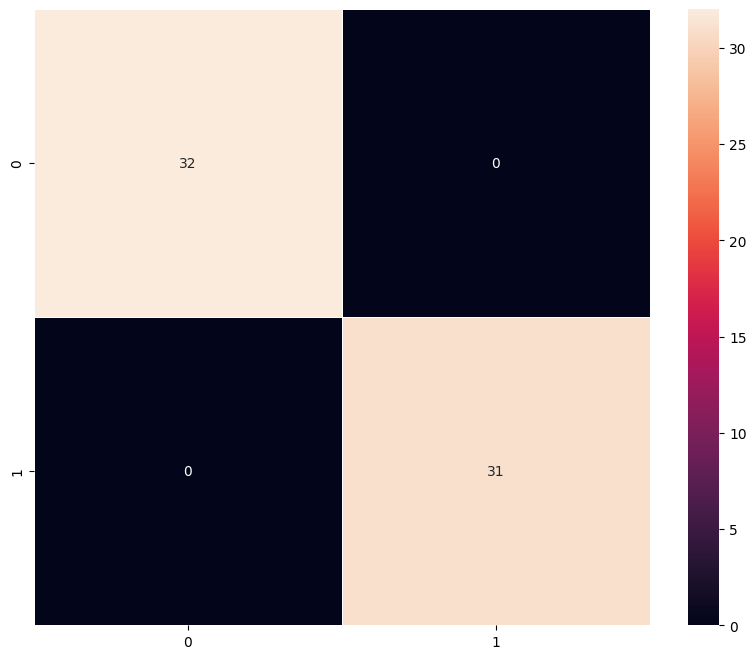

In [23]:
plot_confusion_matrix(model_1,X_val_normalized,y_val)

### Vizualizing the predictions

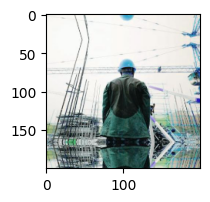

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
Predicted Label: 0
True Label: Label    1
Name: 62, dtype: int64


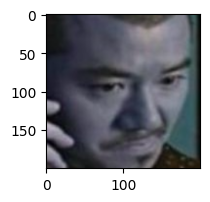

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Label: 0
True Label: Label    0
Name: 512, dtype: int64


In [24]:
# For index 2
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

## Model 2: (VGG-16 (Base))

In [25]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3)) #Complete the code to define the shape of the image
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [31]:
# defines second model (model_2), which is built by taking the pre-trained VGG-16 model (excluding its top layers) and adding new layers on top for specific classification task
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid'))

In [32]:
# compiling  second model (model_2), which is based on the VGG-16 architecture with custom dense layers added on top
opt=Adam(learning_rate=0.001)
# Compile model
model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
# Generating the summary of the model
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [33]:
#initializes an ImageDataGenerator object from the Keras preprocessing module for performing real-time data augmentation. to artificially increase the size of your training dataset by applying various random transformations to your existing images (like rotations, shifts, flips, zooms, etc.). This helps to:
#Prevent Overfitting: By exposing the model to variations of the training images, it becomes more robust and less likely to memorize the training data.
#Improve Model Generalization: The model learns to recognize objects under different conditions and variations, leading to better performance on unseen data.
train_datagen = ImageDataGenerator()

In [34]:
# Epochs
epochs = 10
# Batch size
batch_size = 64

history_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train,
                                      batch_size=batch_size,
                                      seed=42,
                                      shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 8s/step - accuracy: 0.7360 - loss: 0.4345 - val_accuracy: 1.0000 - val_loss: 0.0479
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0529 - val_accuracy: 1.0000 - val_loss: 0.0412
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 306ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 1.0000 - val_loss: 0.0176
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0168 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.0040
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 1.0000 - val_loss: 0.00

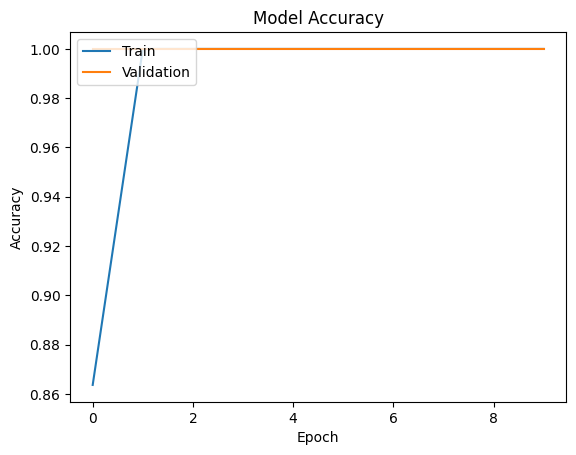

In [35]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [36]:
model_2_train_perf = model_performance_classification(model_2,X_train_normalized,y_train)

print("Train performance metrics")
print(model_2_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 833ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step


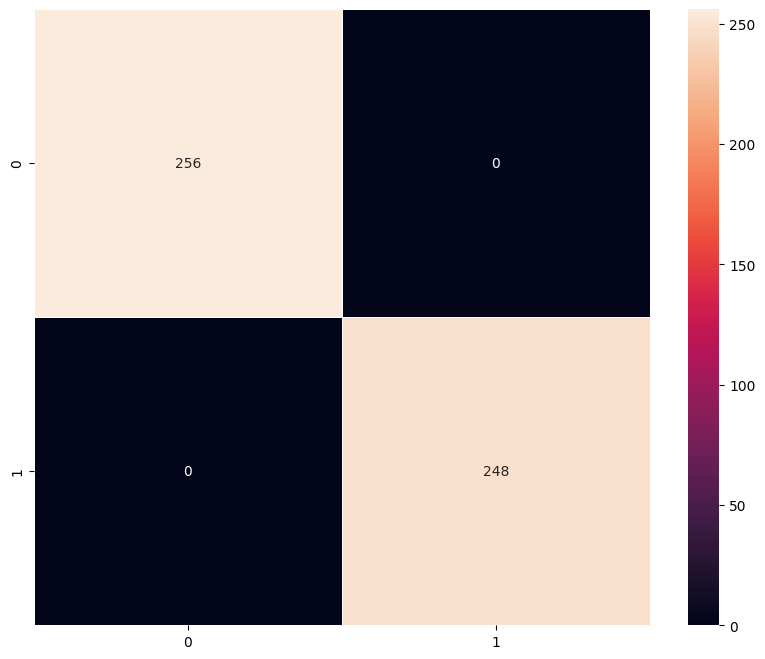

In [37]:
plot_confusion_matrix(model_2,X_train_normalized,y_train)

In [38]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_2_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


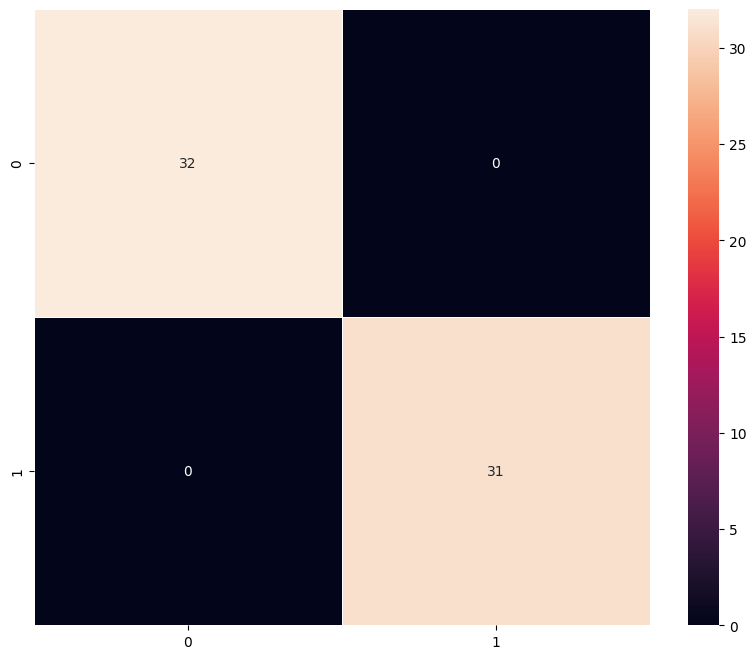

In [39]:
plot_confusion_matrix(model_2,X_val_normalized,y_val)

### Visualizing the prediction:

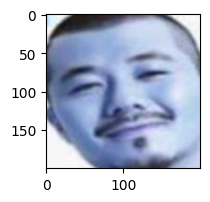

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Label: 0
True Label: Label    0
Name: 603, dtype: int64


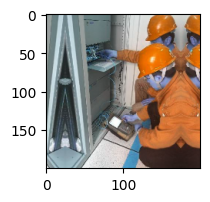

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Label: 0
True Label: Label    0
Name: 547, dtype: int64


In [40]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[2])
plt.show()
prediction = model_2.predict(X_val_normalized[2].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[2] #Complete the code to define the index
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[10]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[2].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[5] #Complete the code to define the index
print('True Label:', true_label)

## Model 3: (VGG-16 (Base + FFNN))

In [48]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(128,activation='relu')) #Complete the code to define the number of neurons and the activation function
model_3.add(Dropout(rate=0.5)) #Complete the code to define the dropout rate
model_3.add(Dense(32,activation='relu')) #Complete the code to define the number of neurons and the activation function

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid')) #Complete the code to define the number of neurons in the output layer and the activation function

In [42]:
opt = Adam()

In [45]:
# Compile model
model_3.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [46]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,079,296 (65.15 MB)

 Trainable params: 2,364,608 (9.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [52]:
history_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False),
                    epochs=10,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 388ms/step - accuracy: 0.6766 - loss: 0.8248 - val_accuracy: 1.0000 - val_loss: 0.0316
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.9707 - loss: 0.0866 - val_accuracy: 1.0000 - val_loss: 4.1042e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 3.0290e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 1.6161e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.9808 - loss: 0.0402 - val_accuracy: 1.0000 - val_loss: 2.1877e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 2.0271e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 1.0000 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 4.3164e-05
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 1.0000 - loss: 5.3070e-04 - val_ac

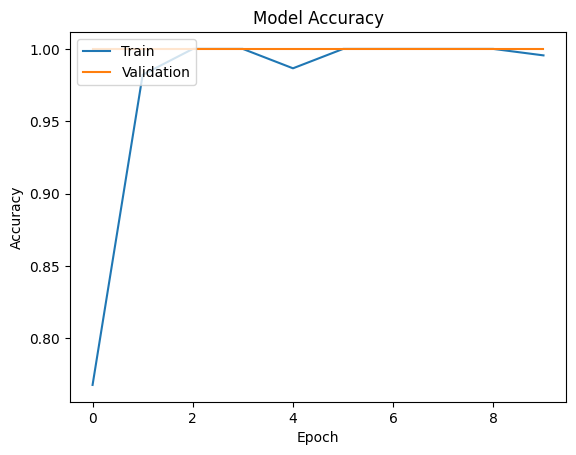

In [53]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy') #Complete the code to define the title for the plot
plt.ylabel('Accuracy') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [54]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train)

print("Train performance metrics")
print(model_3_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step


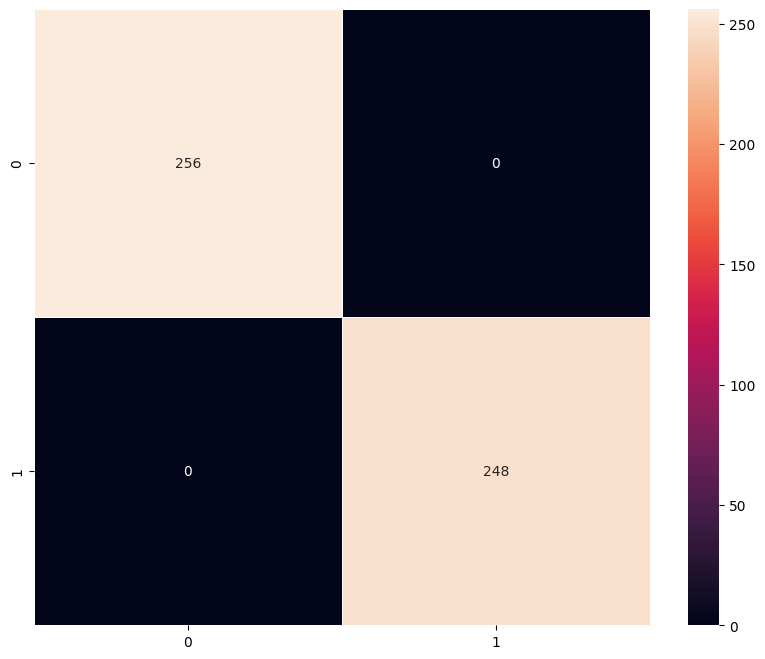

In [55]:
plot_confusion_matrix(model_3,X_train_normalized,y_train)

In [56]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_3_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


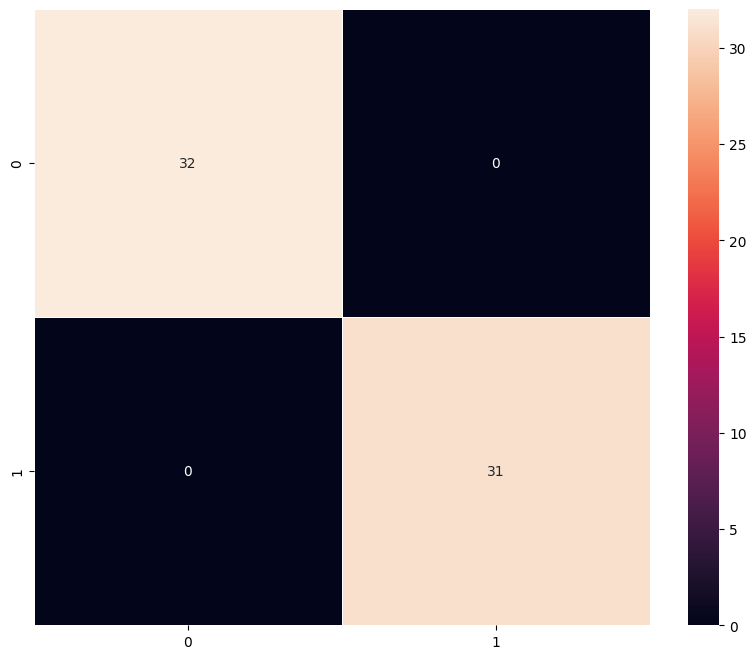

In [57]:
plot_confusion_matrix(model_3,X_val_normalized,y_val)

#### Visualizing the predictions

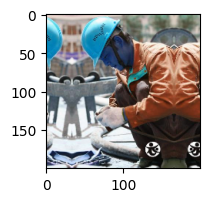

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predicted Label: 1
True Label: Label    1
Name: 127, dtype: int64


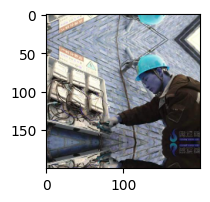

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted Label: 1
True Label: Label    1
Name: 108, dtype: int64


In [60]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[3])
plt.show()
prediction = model_2.predict(X_val_normalized[3].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[3]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[1])
plt.show()
prediction = model_2.predict(X_val_normalized[1].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[1]
print('True Label:', true_label)

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [68]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(256,activation='relu'))
model_4.add(Dropout(rate=0.4))
model_4.add(Dense(32,activation='relu'))

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid'))

In [69]:
opt=Adam(learning_rate=0.001)
# Compile model
model_4.compile(optimizer=opt,   loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"]) #Complete the code to define the metrics

In [70]:
# Generating the summary of the model
model_4.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,441,793 (74.16 MB)

 Trainable params: 4,727,105 (18.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [71]:
# Applying data augmentation
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2
                              )


In [72]:
history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=32,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 818ms/step - accuracy: 0.7113 - loss: 0.6406 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step - accuracy: 0.9934 - loss: 0.0280 - val_accuracy: 1.0000 - val_loss: 7.2334e-04
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9847 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 6.9561e-04
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 334ms/step - accuracy: 0.9932 - loss: 0.0263 - val_accuracy: 1.0000 - val_loss: 1.2206e-05
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.9913 - loss: 0.0276 - val_accuracy: 1.0000 - val_loss: 1.2368e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9821 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 1.1175e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 1.0000 - loss: 4.4052e-04 - val_accuracy: 1.0000 - val_loss: 7.1357e-05
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 1.0000 - loss: 0.0030 - val_a

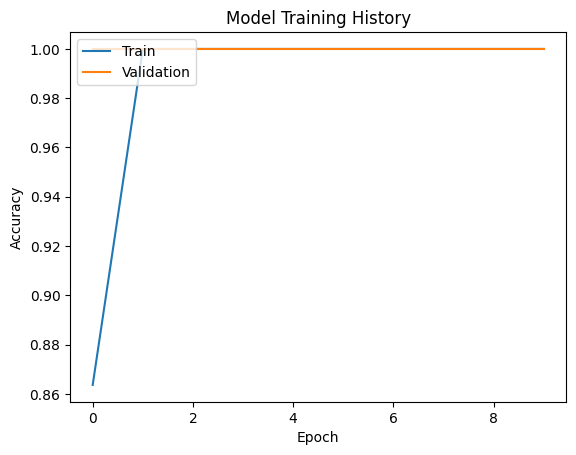

In [73]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Training History') #Complete the code to define the title for the plot
plt.ylabel('Accuracy') #Complete the code to define the label for the y-axis
plt.xlabel('Epoch') #Complete the code to define the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [74]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized,y_train)

print("Train performance metrics")
print(model_4_train_perf)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step


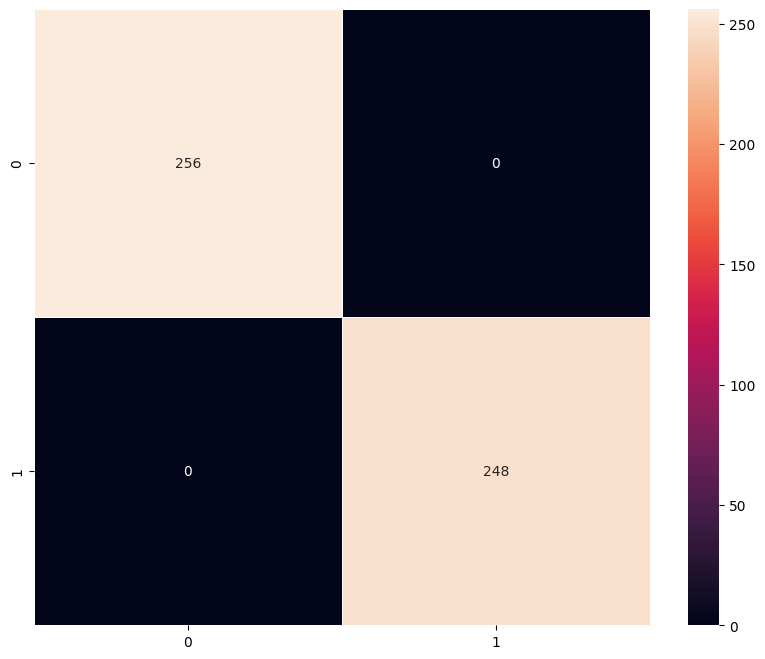

In [75]:
plot_confusion_matrix(model_4,X_train_normalized,y_train)

In [76]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_4_valid_perf)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 499ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


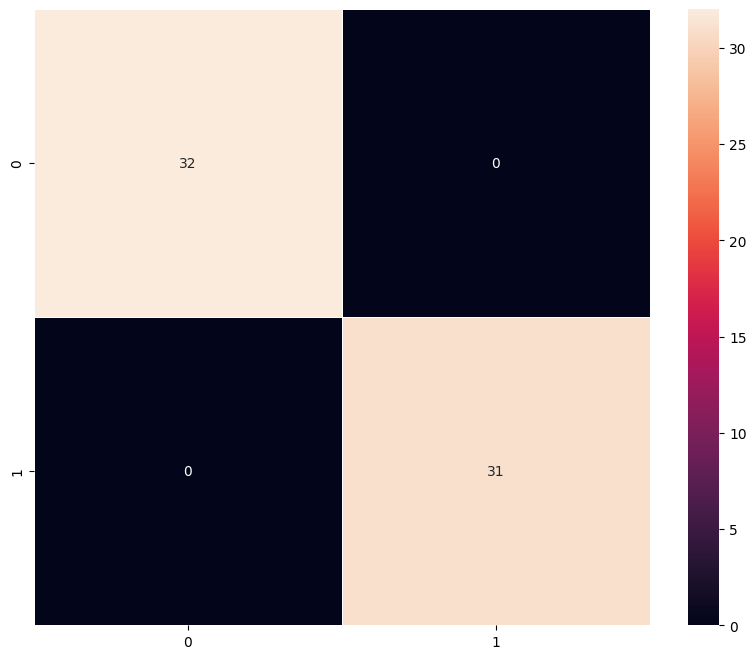

In [77]:
plot_confusion_matrix(model_4,X_val_normalized,y_val)

#### Visualizing the predictions

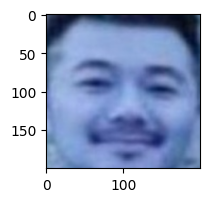

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Label: 0
True Label: Label    0
Name: 314, dtype: int64


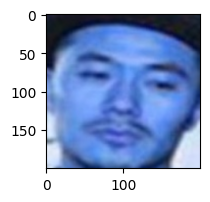

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Label: 0
True Label: Label    0
Name: 485, dtype: int64


In [78]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[4])
plt.show()
prediction = model_2.predict(X_val_normalized[4].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[4]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[11])
plt.show()
prediction = model_2.predict(X_val_normalized[11].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[11]
print('True Label:', true_label)

# **Model Performance Comparison and Final Model Selection**

In [79]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [80]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [81]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [82]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [83]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.0,0.0,0.0,0.0
Recall,0.0,0.0,0.0,0.0
Precision,0.0,0.0,0.0,0.0
F1 Score,0.0,0.0,0.0,0.0


## Test Performance

In [85]:
model_test_perf = model_performance_classification(model_4, X_test_normalized,y_test) #Complete the code to pass the best model (Pass the variable corresponding to it. For example, model_1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


In [86]:
model_test_perf

,Accuracy,Recall,Precision,F1 Score
0,1.0,1.0,1.0,1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


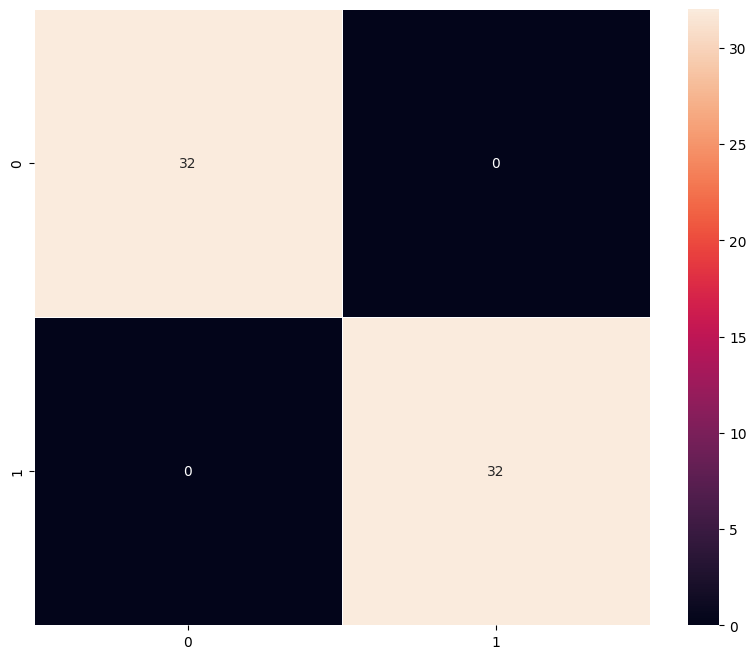

In [87]:
plot_confusion_matrix(model_4, X_test_normalized,y_test) #Complete the code to pass the best model (Pass the variable corresponding to it. For example, model_1)

# **Actionable Insights & Recommendations**

Given that all models performed perfectly on the training and validation sets, it's difficult to definitively choose the "best" model solely based on these metrics. However, we can consider a few factors:

* Model Complexity: The Simple CNN (model_1) is the least complex model. While it achieved perfect performance, it might be more prone to overfitting on a larger or more diverse dataset compared to the VGG-16 based models.
* Transfer Learning: Models 2, 3, and 4 utilize transfer learning with the VGG-16 base. This approach is generally more robust and can lead to better generalization on unseen data, especially with limited datasets.
* Data Augmentation: Model 4 incorporates data augmentation. While it didn't show a difference in performance on this dataset (likely due to the small size and already high performance), data augmentation is a crucial technique for improving model robustness and generalization in real-world scenarios with more varied data.
* Considering these factors, Model 4 (VGG-16 (Base + FFNN + Data Augmentation)) is the most promising model for a real-world application. Although all models performed perfectly on the provided data, Model 4's architecture (transfer learning with a more complex FFNN) and the use of data augmentation make it more likely to generalize well to new, unseen images with variations in conditions and activities.

Key Takeaways for the Business:

* SafeGuard Corp has a strong foundation for building an automated safety helmet monitoring system with the developed Model 4.
* The chosen approach leveraging transfer learning and data augmentation provides a good balance of performance and potential for generalization.
* While initial results are perfect on the provided data, thorough testing with more diverse real-world data and evaluation of operational aspects like inference speed are essential before full-scale deployment.
* A strategy for continuous monitoring and model improvement will be necessary to maintain high performance in a dynamic real-world environment.

These insights and recommendations should guide SafeGuard Corp in the next steps of developing and deploying their automated image analysis system for improved workplace safety.

-
-

<font size=5 color='blue'>Power Ahead!</font>
___